In [1]:
import copy
import datetime
import gc
import logging
import os
from math import exp, floor, sqrt

import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import psutil
import seaborn as sns
import tensorflow as tf
import tqdm.notebook as tq
from minepy import MINE
from numpy import mean
from sklearn.cluster import KMeans
from sklearn.datasets import make_classification
from sklearn.ensemble import AdaBoostClassifier
from sklearn.inspection import permutation_importance
from sklearn.metrics import (accuracy_score, auc, f1_score, precision_score,
                             recall_score, roc_auc_score, silhouette_score)
from sklearn.model_selection import (GridSearchCV, RepeatedStratifiedKFold,
                                     ShuffleSplit, StratifiedShuffleSplit,
                                     cross_val_score)
from tqdm.notebook import tqdm
from tslearn.barycenters import (dtw_barycenter_averaging,
                                 dtw_barycenter_averaging_subgradient,
                                 euclidean_barycenter, softdtw_barycenter)
from tslearn.clustering import TimeSeriesKMeans
from tslearn.datasets import CachedDatasets
from tslearn.metrics import dtw, soft_dtw
from tslearn.preprocessing import (TimeSeriesResampler,
                                   TimeSeriesScalerMeanVariance)
from xgboost import XGBClassifier

# data acquisition and pre-processing

## data acquisition

In [2]:
def get_file_from_folder(path):
    data = {}
    data_path = path
    headers = ["MeterID", "Datetime", "Electricity"]

    for file_name in os.listdir(data_path):
        file_path = os.path.join(data_path, file_name)

        df = pd.read_csv(file_path, sep=" ", names=headers)
        data[file_name] = df

    return data

def transform_daycode_to_date(days_int):
    days = int(str(days_int)[:3])
    add_date = datetime.timedelta(days=days)
    current_date = START_DATE + add_date
    return str(current_date)

def transform_dataframe(df):
    df = df.sort_values(by = ['MeterID', 'Datetime'])

    df["Day"] = df["Datetime"].map(lambda x: transform_daycode_to_date(x))
    df["Time"] = df["Datetime"].map(lambda x: str(x)[3:])
    df["Time"] = pd.to_numeric(df["Time"], downcast='integer')

    df = df[['MeterID','Day', 'Time', 'Electricity', 'Datetime']]
    return df

def print_df_summary(df, all=False):
    print(f"MeterID count : {df.value_counts('MeterID').unique()}")
    print(f"Datetime count : {df.value_counts('Datetime').unique()}")
    if all == True:
        print(f"Day count : {df.value_counts('Day').unique()}")
        print(f"Time count : {df.value_counts('Time').unique()}")
        print(f"Electricity count : {df.value_counts('Electricity').unique()}")

In [3]:
# data preprocessing CONST
DATA_FOLDER_PATH = "Data"
IMAGES_PATH = "Image"
ALLOCATION_PATH = "SME and Residential allocations.xlsx"
START_DATE = datetime.date(2009, 1, 1)
MAX_NUMBER_OF_HOURS = 530 * 24 * 2
HOURS_LIST = np.arange(MAX_NUMBER_OF_HOURS)

In [ ]:
# read data from folder
data = get_file_from_folder(DATA_FOLDER_PATH)

In [ ]:
# get residential list
res_list = []
df_sme = pd.read_excel(ALLOCATION_PATH, usecols="A:B")
df_sme = df_sme.loc[df_sme['Code'] == 1]
res_list = df_sme['ID'].tolist()

In [ ]:
# filter res data and specific date
res_data_list = []
for index, name in enumerate(data):
    d = data[name]['MeterID'].isin(res_list)
    d_is_res = data[name].loc[d]
    
    d_is_res_and_date = transform_dataframe(d_is_res)
    
    res_data_list.append(d_is_res_and_date)

In [ ]:
load_data = pd.concat(res_data_list, copy=False)
load_data.head(10)

In [ ]:
load_data.shape

## Data cleaning

In [43]:
def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300, image_path = IMAGES_PATH):
    path = os.path.join(image_path, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

In [ ]:
def plot_day_data(data, x="Day", rotation=45, y="Data quantity", title="data quantity for each day in residential meter",save=False):
    plt.figure(dpi=150, figsize=(10,4))
    plt.plot(data)

    # naming the x axis 
    plt.xlabel(x) 
    plt.xticks(np.arange(0, len(data), 20), rotation=45)
    # naming the y axis 
    plt.ylabel(y) 

    # giving a title to my graph 
    plt.title(title)
    if save == True:
        save_fig(title)

In [ ]:
# data cleaning functions
# drop data has eletricity comsuption with 0
def data_cleaning_drop_zero(pretty_data):
    print(f'before drop zero: {pretty_data.shape}')
    pretty_data = pretty_data.groupby("MeterID")
    pretty_data = pretty_data.filter(lambda x: ( round(x['Electricity'].eq(0).sum() / x['Electricity'].count(), 2) < 0.01) )
    print(f'after drop zero:  {pretty_data.shape}')
    return pretty_data

# drop data has more than T hours
def data_cleaning_drop_48(pretty_data, time=48):
    print(f'before drop Time: {pretty_data.shape}')
    pretty_data = pretty_data[ pd.to_numeric(pretty_data["Time"], downcast='integer') <= time ]
    print(f'after drop Time:  {pretty_data.shape}')
    return pretty_data

# select data between min and max Datetime 
def data_cleaning_select_time(pretty_data, min_date, max_date):
    print(f'before drop Datetime between {min_date} and {max_date}:  {pretty_data.shape}')
    pretty_data = pretty_data[ ((pretty_data['Datetime'] >= min_date) & (pretty_data['Datetime'] <= max_date)) ]
    print(f'after drop Datetime between {min_date} and {max_date}:  {pretty_data.shape}')
    return pretty_data

# drop data from specific column and specific value
def drop_meter_from_df(pretty_data, column, value):
    return pretty_data[~pretty_data[column].isin(value)]

def plot_df_valuecounts_with_groupby(pretty_data, byColumn, column=False):
    print(pretty_data.groupby(byColumn).count()["Time"].value_counts())
    if column:
        pretty_data.groupby(byColumn).count()[column].value_counts().plot.bar()
    else:
        pretty_data.groupby(byColumn).count().value_counts().plot.bar()
        
def replace_missing_value(df, meter_id, meter_day, replace_day, day_interval=1): 
    #day_interval is used to change the datetime
    #meter_day is the day with data
    #replace_day is the missing day
    display(df[ (df["MeterID"]==meter_id) & (df["Day"]==replace_day)].head(2))
    df_temp = df[ (df["MeterID"]==meter_id) & (df["Day"]==meter_day)]
    df_temp = df_temp.replace(to_replace=r""+meter_day, value=replace_day)
    df_temp["Datetime"] = df_temp["Datetime"].add(day_interval*100)
    df = df.append(df_temp)
    display(df[ (df["MeterID"]==meter_id) & (df["Day"]==replace_day)].head(2))
    return df

In [ ]:
plot_day_data(load_data["Day"].value_counts().sort_index(), title="data quantity for each day in residential meter", save=True)

### select time interval

In [ ]:
load_data = data_cleaning_select_time(load_data,19501,72948)
plot_day_data(load_data["Day"].value_counts().sort_index(), title="data quantity in select time 2009.7.15-2010.12.31", save=True)
print(load_data.shape)
data_20110101 = data_cleaning_select_time(load_data,73001,73048)

### drop more than 48 hours

In [ ]:
load_data = data_cleaning_drop_48(load_data)
plot_day_data(load_data["Day"].value_counts().sort_index(), title="drop data more than 48 hours a day", save=True)
print(load_data.shape)

### drop missing value

 2010-12-24    202416
 2010-12-05    200736
 2010-12-06    195936
 2010-03-29    194350
 2010-07-21    182016

In [ ]:
# drop data with day missing
drop_Day_missing = ["2010-03-29", "2010-12-24", "2010-12-05", "2010-12-06", "2010-07-21"]
load_data = drop_meter_from_df(load_data, "Day", drop_Day_missing)
plot_day_data(load_data["Day"].value_counts().sort_index(), title="drop data with day missing", save=True)
print(load_data.shape)

### replace missing value

 2010-11-17    202752
 2010-11-16    202752
 2009-09-04    202704
 2010-07-20    202704
 2010-12-04    202704

In [ ]:
print(set(load_data["MeterID"].unique()) - set(load_data[ load_data["Day"]=="2010-11-16"]["MeterID"].unique()))
print(set(load_data["MeterID"].unique()) - set(load_data[ load_data["Day"]=="2010-11-17"]["MeterID"].unique()))
print(set(load_data["MeterID"].unique()) - set(load_data[ load_data["Day"]=="2009-09-04"]["MeterID"].unique()))
print(set(load_data["MeterID"].unique()) - set(load_data[ load_data["Day"]=="2010-07-20"]["MeterID"].unique()))
print(set(load_data["MeterID"].unique()) - set(load_data[ load_data["Day"]=="2010-12-04"]["MeterID"].unique()))

In [ ]:
load_data = replace_missing_value(load_data, 4463, "2010-11-15", "2010-11-16", 1)
load_data = replace_missing_value(load_data, 4463, "2010-11-14", "2010-11-17", 1)
load_data = replace_missing_value(load_data, 2715, "2009-09-03", "2009-09-04", 1)
load_data = replace_missing_value(load_data, 5313, "2009-09-03", "2009-09-04", 1)
load_data = replace_missing_value(load_data, 3433, "2010-07-19", "2010-07-20", 1)
load_data = replace_missing_value(load_data, 5181, "2010-07-19", "2010-07-20", 1)
load_data = replace_missing_value(load_data, 1505, "2010-12-03", "2010-12-04", 1)
load_data = replace_missing_value(load_data, 2728, "2010-12-03", "2010-12-04", 1)

In [ ]:
# e = load_data.to_csv(index=False)
# f = open('load_data.csv','w')
# f.write(e) #Give your csv text here.
# ## Python will convert \n to os.linesep
# f.close()

In [ ]:
plot_day_data(load_data["Day"].value_counts().sort_index(), title="fill data with day missing", save=True)
print(load_data.shape)

In [ ]:
del data
del d
del df_sme
del d_is_res
del res_list
del d_is_res_and_date
del res_data_list
gc.collect()

## Meter grouping

In [ ]:
pretty_data = load_data.sort_values(by=['MeterID', 'Day'])

In [ ]:
# FDI CONST
NUMBER_OF_DAYS = len(pretty_data["Day"].unique())
NUMBER_OF_HALF_HOURS = NUMBER_OF_DAYS * 48
AREA_NUM = 10
TOTAL_METER = len(pretty_data.groupby("MeterID")["MeterID"].unique())
METER_IN_RANGE = round(len(pretty_data.groupby("MeterID")["MeterID"].unique()) / AREA_NUM)

In [ ]:
NUMBER_OF_DAYS, NUMBER_OF_HALF_HOURS, TOTAL_METER, METER_IN_RANGE

In [ ]:
# split data into groups
def split_data_to_group(target_df, areas):
    data_group = {}
    for group in range(areas):
        if group == (AREA_NUM - 1):
            data_group[group] = target_df[METER_IN_RANGE*group*(NUMBER_OF_HALF_HOURS) : METER_IN_RANGE*(group+1)*(NUMBER_OF_HALF_HOURS)+NUMBER_OF_HALF_HOURS* (TOTAL_METER % areas)]
        else:
            data_group[group] = target_df[METER_IN_RANGE*group*(NUMBER_OF_HALF_HOURS) : METER_IN_RANGE*(group+1)*(NUMBER_OF_HALF_HOURS)]
    return data_group

In [ ]:
# split data into 10 groups
data_group = split_data_to_group(pretty_data, AREA_NUM)

## FDI

In [ ]:
class FdiGenerator:
    def __init__(self):
        self.alpha_max = 0.8
        self.alpha_min = 0.2
    
    # x is the origin value

    def fdi_1(self, x):
        fdi =  x * self.get_alpha()
        return fdi

    def fdi_2(self, x, df_max):
        alpha = self.get_alpha()
        gamma = alpha * df_max
        return gamma if (x > gamma) else x

    def fdi_3(self, x, df_max):
        gamma = np.random.uniform(0, 1) * df_max
        return max((x - gamma), 0)
    
    def fdi_4(self, x, index, total_index):
        t2 = np.random.randint(0, 20)
        t1 = np.random.randint(t2, 24)
        if index > t2 and index < t2:
            return 0
        return x
    
    def fdi_5(self, x, index):
        alpha = self.get_alpha()
        return x * alpha
    
    def fdi_6(self, avg_x):
        alpha = self.get_alpha()
        return avg_x * alpha
    
    def get_alpha(self):
        return np.random.uniform(self.alpha_min, self.alpha_max)
    
    def get_random_mode(self):
        # return an integer in range from 1 to 6
        fdi_method = np.random.randint(1, 7)
        return fdi_method
    
    def random_fdi(self, fdi_method, x, df, index):
        # return a fdi value with fdi_method provided
        if fdi_method == 1:
            return self.fdi_1(x)
        elif fdi_method == 2:
            return self.fdi_2(x, df.max())
        elif fdi_method == 3:
            return self.fdi_3(x, df.max())
        elif fdi_method == 4:
            return self.fdi_4(x, index, df.shape[0])
        elif fdi_method == 5:
            return self.fdi_5(x, index)
        else:
            return self.fdi_6(df.mean())

In [ ]:
def split_group(group, total_meter, area_num, group_meter, total_day, ntl_meter_ratio, ntl_day_ratio):
    # ex: split_group(data_group, total_meter = 2044, group_meter = 204, total_day = 299, ntl_meter_ratio = 0.1, ntl_day_ratio = 0.5)

    ntl_num = round(group_meter * ntl_meter_ratio) # ntl_num = how many number of ntl meters
    ntl_day_num = round(total_day * ntl_day_ratio) # ntl_day_num = how many days are fdi for ntl meters
    
    np.random.seed(42)
    
    final_data_group = []
    origin_data_group = []
    data_group = copy.deepcopy(group) 
    
    # iterate through 10 area
    for group, data in data_group.items():
        
        final_data = {}
        origin_data = {}

        normal_data = []
        fdi_data = []
        origin_fdi_data = []

        if group == (area_num - 1): # the last group will have more data for the rest of the meters
            num = total_meter - group_meter * (area_num -1)
        else:
            num = group_meter

        #split total meter into normal meters and fdi meters
        rs = ShuffleSplit(n_splits=1, test_size=ntl_num)
        for normal_index, fdi_index in rs.split(range(num)):
            for index in normal_index:
                normal_data.append(data[index*(NUMBER_OF_HALF_HOURS):(index+1)*(NUMBER_OF_HALF_HOURS)])
            for index in fdi_index:
                fdi_data.append(data[index*(NUMBER_OF_HALF_HOURS):(index+1)*(NUMBER_OF_HALF_HOURS)])
                
        origin_fdi_data = copy.deepcopy(fdi_data)
            
        for index in tq.tqdm(range(len(fdi_data))):

            dataframe = fdi_data[index]
            fdi_dataframe = np.zeros((NUMBER_OF_HALF_HOURS))
            
            # split total day into normal and fdi day with the ntl_day_num
            rs = ShuffleSplit(n_splits=1, test_size=ntl_day_num, random_state=42)
            for normal_day, fdi_day in rs.split(range(total_day)):
                normal_day = normal_day
                fdi_day = fdi_day
            
            # set normal data in normal days
            for day in range(len(normal_day)):
                for i in range(normal_day[day]*48, (normal_day[day]+1)*48):
                    fdi_dataframe[i] = dataframe["Electricity"].iloc[[i]]
            
            # process FDI in fdi days
            for day in range(len(fdi_day)):
                  for i in range(fdi_day[day]*48, (fdi_day[day]+1)*48):
                        
                        # one day has 48 data, so every 48 will change a fdi mode
                        if i%48 == 0:
                            fdi_method = FDI.get_random_mode()
                        
                        origin_value = dataframe["Electricity"].iloc[i]
                        fdi_dataframe[i] = FDI.random_fdi(fdi_method, origin_value, dataframe["Electricity"], i)

            fdi_data[index]["Electricity"] = fdi_dataframe

        final_data["normal"] = normal_data
        final_data["fdi"] = fdi_data
        final_data_group.append(final_data) 

        origin_data["normal"] = normal_data
        origin_data["fdi"] = origin_fdi_data
        origin_data_group.append(origin_data)

    return final_data_group, origin_data_group

In [ ]:
FDI = FdiGenerator()
final_data_group, origin_data_group = split_group(data_group, total_meter=TOTAL_METER, area_num=AREA_NUM, total_day=NUMBER_OF_DAYS, group_meter=METER_IN_RANGE, ntl_meter_ratio=0.1, ntl_day_ratio=0.5)

In [ ]:
def plot_data(normal_data, fdi_data, title, label1, label2, plot_house=5, plot_hour=120, save=False):
    #plotting the points  
    plt.figure(dpi=150, figsize=(15,4))
    if normal_data is not None:
        count = 0
    for i in range(len(normal_data)):
        data = normal_data[i]["Electricity"]
        count += 1
        if count>plot_house:
            break
        plt.plot(HOURS_LIST[:plot_hour], data[:plot_hour], color='blue') 

    if fdi_data is not None:
        count = 0
    for i in range(len(fdi_data)):
        data = fdi_data[i]["Electricity"]
        count += 1
        if count>plot_house:
            break
        plt.plot(HOURS_LIST[:plot_hour], data[:plot_hour], color='red')
    
    
    blue_patch = mpatches.Patch(color='blue', label=label1)
    red_patch = mpatches.Patch(color='red', label=label2)
    plt.legend(handles=[blue_patch, red_patch])       
        
    # naming the x axis 
    plt.xlabel('Half Hours') 
    # naming the y axis 
    plt.ylabel('Electricity Consumption(W)') 

    # giving a title to my graph 
    plt.title(title) 

    # function to save the plot
    if save == True:
        save_fig(title)

    # function to show the plot 
    plt.show()

In [ ]:
for i in range(len(final_data_group)):
    if i == 2: break
    plot_data(origin_data_group[i]["fdi"], final_data_group[i]["fdi"], "actual consumption of all consumers of group " + str(i), "normal data", "fdi data", plot_house=1, plot_hour=NUMBER_OF_HALF_HOURS, save=False)

## check NTL

In [ ]:
# observe_meter_data_group = copy.deepcopy(origin_data_group) ## data without fdi
# smart_meter_data_group = copy.deepcopy(final_data_group) ## data with fdi
observe_meter_data_group = origin_data_group ## data without fdi
smart_meter_data_group = final_data_group ## data with fdi

In [ ]:
# calculate NTL loss vector for every day
ntl_loss_data_group = []
for observe_area, smart_area in zip(observe_meter_data_group, smart_meter_data_group): # iterate 10 area
    ntl_loss_data = []
    for observe_meter, smart_meter in zip(observe_area['fdi'], smart_area['fdi']): #iterate fdi meter in each area
        
        sub = observe_meter[["Electricity"]] - smart_meter[["Electricity"]]

        ntl_loss_data = sub.to_numpy().reshape(NUMBER_OF_DAYS, 48) 

    ntl_loss_data_group.append(ntl_loss_data)
ntl_loss_data_group = np.asarray(ntl_loss_data_group)
ntl_loss_data_group.shape

In [ ]:
# make sure there is difference between the observe_meter_data_group and smart_meter_data_group
plt.plot(observe_meter_data_group[0]["fdi"][0]["Electricity"].tolist())
plt.plot(smart_meter_data_group[0]["fdi"][0]["Electricity"].tolist()) 
for j in range(1):
    t = observe_meter_data_group[0]["fdi"][j]["Electricity"] - smart_meter_data_group[0]["fdi"][j]["Electricity"]
    print(t.value_counts())

In [ ]:
# smart meter to csv
smart_meter_list = []
smart_meter_df = pd.DataFrame(columns=['MeterID', 'Day', 'FDI','Electricity'])
pbar = tqdm(smart_meter_data_group) 
for area in pbar: # iterate 10 data groups
    for meter in area['fdi']: # iterate every fdi meter in area 
        meter['FDI']='True'
        smart_meter_list.append(meter.to_numpy())
    for meter in area['normal']:
        meter['FDI']='False'
        smart_meter_list.append(meter.to_numpy())
#             se = {'MeterID': meter_id, 'Day': meter_day,'FDI':True }
#             v_value_list.append(se)

# df = pd.DataFrame(np.array(smart_meter_list).reshape(-1, 6), columns=["MeterID","Day","Time","Electricity","Datetime", "FDI"])
# df.head()
# df = df[["MeterID","Day","Time","Electricity","FDI"]]
# e = df.to_csv(index=False)
# f = open('smart_meter.csv','w')
# f.write(e) #Give your csv text here.
# f.close()

## k-mean index

In [52]:
X = []
X_meter = []
Y = []
for i in range(10):
    data = final_data_group[i]
    for normal in data["normal"]:
        X.append(normal["Electricity"].to_numpy())
        X_meter.append(normal["MeterID"].iloc[0])
        Y.append([0])
    for fdi in data["fdi"]:
        X.append(fdi["Electricity"].to_numpy())
        X_meter.append(normal["MeterID"].iloc[0])
        Y.append([1])
X = np.array(X)
X_meter = np.array(X_meter)
Y = np.array(Y).reshape(-1)
print(X.shape)

(4225, 25440)


### silhouette index

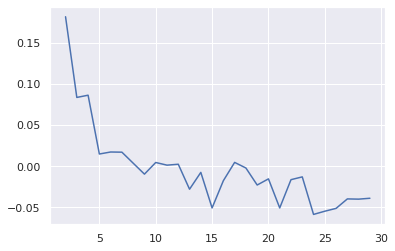

In [288]:
# silhouette index
silhouette_avg = []
for i in tq.tqdm(range(2,30)):
    kmeans_fit = KMeans(n_clusters = i).fit(X)
    silhouette_avg.append(silhouette_score(X, kmeans_fit.labels_))
plt.plot(range(2,30), silhouette_avg)

Saving figure Silhouette analysis in fdi data


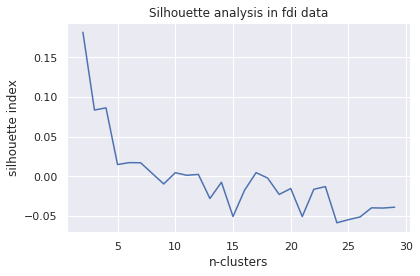

In [295]:
plt.title("Silhouette analysis in fdi data")
plt.xlabel('n-clusters') 
# naming the y axis 
plt.ylabel('silhouette index') 
plt.plot(range(2,30), silhouette_avg)
save_fig("Silhouette analysis in fdi data")

# Feature extraction

## V-value

### normalization

In [54]:
# the value of x is divided by its
# maximum and scaled into a value between zero and one
# normalized smart_meter_data_group by divide the max eletricity of the meter
for area in smart_meter_data_group:
    for meter in area['fdi']:
        meter_numpy = meter['Electricity'].to_numpy()
        meter['Electricity'] = meter_numpy / meter_numpy.max()
    for meter in area['normal']:
        meter_numpy = meter['Electricity'].to_numpy()
        meter['Electricity'] = meter_numpy / meter_numpy.max()
smart_meter_data_group[0]['fdi'][0]['Electricity'].to_numpy()

array([0.03036384, 0.0293429 , 0.02573139, ..., 0.02866607, 0.02366506,
       0.04255409])

0.130453    174
0.127911    166
0.125370    161
0.123676    158
0.126217    155
           ... 
0.119941      1
0.572266      1
0.117637      1
0.350362      1
0.107493      1
Name: Electricity, Length: 8930, dtype: int64


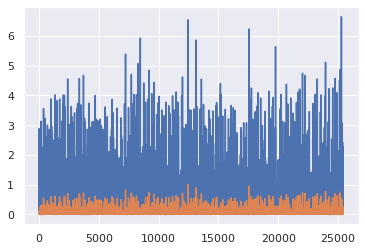

In [55]:
# make sure there is difference between the observe_meter_data_group and smart_meter_data_group
plt.plot(observe_meter_data_group[0]["fdi"][0]["Electricity"].tolist())
plt.plot(smart_meter_data_group[0]["fdi"][0]["Electricity"].tolist()) 
for j in range(1):
    t = observe_meter_data_group[0]["fdi"][j]["Electricity"] - smart_meter_data_group[0]["fdi"][j]["Electricity"]
    print(t.value_counts())

### calculate v-value

In [58]:
CONDITION_FILTER = 28
v_value_list = []
v_value_df = pd.DataFrame(columns=['MeterID', 'Day', 'FDI', 'Tmax1', 'Cmax1', 'Tmax2', 'Cmax2', 'Tmin1', 'Cmin1'])
pbar = tqdm(smart_meter_data_group) 
for area in pbar: # iterate 10 data groups
    for meter in area['fdi']: # iterate every fdi meter in area 
        day_list = meter['Day'].reset_index()
        for i in range(NUMBER_OF_DAYS): # iterate every day
            meter_id = meter['MeterID'].max()
            meter_day = day_list['Day'][i*48]
            meter_numpy = meter['Electricity'].to_numpy()[i*48:(i+1)*48]

            # 1. Cmax1 and T max1 are the maximum consumption before 2 p.m.
            Tmax1 = meter_numpy[:CONDITION_FILTER].argmax()
            
            # 2. Cmax2 and T max2 are the maximum consumption after 2 p.m.
            Tmax2 = meter_numpy[CONDITION_FILTER:].argmax() + CONDITION_FILTER
            
            # 3. Cmin1 and T min1 are the minimum consumption between T max1 and T max2 
            Tmin1 = meter_numpy[Tmax1: Tmax2].argmin() + Tmax1
            
            se = {'MeterID': meter_id, 'Day': meter_day,'FDI': True, 'Tmax1': Tmax1, 'Tmax2': Tmax2, 'Tmin1': Tmin1, 'Cmax1': meter_numpy[Tmax1], 'Cmax2': meter_numpy[Tmax2], 'Cmin1': meter_numpy[Tmin1]}
            v_value_list.append(se)
    print('finish fdi')
    for meter in area['normal']:
        day_list = meter['Day'].reset_index()
        for i in range(NUMBER_OF_DAYS): # iterate every day
            meter_id = meter['MeterID'].max()
            meter_day = day_list['Day'][i*48]
            meter_numpy = meter['Electricity'].to_numpy()[i*48:(i+1)*48]
#             print(meter_numpy)
            # 1. Cmax1 and T max1 are the maximum consumption before 2 p.m.
            Tmax1 = meter_numpy[:CONDITION_FILTER].argmax()
            
            # 2. Cmax2 and T max2 are the maximum consumption after 2 p.m.
            Tmax2 = meter_numpy[CONDITION_FILTER:].argmax() + CONDITION_FILTER
            
            # 3. Cmin1 and T min1 are the minimum consumption between T max1 and T max2 
            Tmin1 = meter_numpy[Tmax1: Tmax2].argmin() + Tmax1
            
            se = {'MeterID': meter_id, 'Day': meter_day,'FDI': False, 'Tmax1': Tmax1, 'Tmax2': Tmax2, 'Tmin1': Tmin1, 'Cmax1': meter_numpy[Tmax1], 'Cmax2': meter_numpy[Tmax2], 'Cmin1': meter_numpy[Tmin1]}
            v_value_list.append(se)
    print('finish normal')

  0%|          | 0/10 [00:00<?, ?it/s]

finish fdi
finish normal
finish fdi
finish normal
finish fdi
finish normal
finish fdi
finish normal
finish fdi
finish normal
finish fdi
finish normal
finish fdi
finish normal
finish fdi
finish normal
finish fdi
finish normal
finish fdi
finish normal


In [59]:
df = pd.DataFrame(v_value_list)
df.head()

,MeterID,Day,FDI,Tmax1,Tmax2,Tmin1,Cmax1,Cmax2,Cmin1
0,5212,2010-12-31,True,12,30,15,0.046464,0.047532,0.013561
1,5212,2010-12-31,True,27,38,36,0.217125,0.231040,0.021254
2,5212,2010-12-31,True,26,42,34,0.184098,0.277676,0.021560
3,5212,2010-12-31,True,0,28,0,0.000000,0.000000,0.000000
4,5212,2010-12-31,True,0,39,19,0.082569,0.313303,0.020948


In [63]:
e = df.to_csv(index=False)
f = open('v_value.csv','w')
f.write(e) #Give your csv text here.
## Python will convert \n to os.linesep
f.close()

In [ ]:
del meter_day
del meter_id
del meter_numpy
del e
del f
del df
gc.collect()

### calculate distance

In [193]:
def dV(i,j):
    return ( (i.Tmax1-j.Tmax1)**2 + (i.Cmax1-j.Cmax1)**2 )**0.5 + ( (i.Tmax2-j.Tmax2)**2 + (i.Cmax2-j.Cmax2)**2 )**0.5 + ( (i.Tmin1-j.Tmin1)**2 + (i.Cmin1-j.Cmin1)**2 )**0.5

In [ ]:
def calculate_distance(df):
    vvalue_distance_matrix = []
    for indexi, rowi in tq.tqdm(df.iterrows()):
        i_j_distance_arr = []
        for indexj, rowj in tq.tqdm(df.iterrows()):
            if indexi > indexj:
                i_j_distance_arr.append(vvalue_distance_matrix[indexj][indexi])
                continue
            i_j_distance_arr.append(dV(rowi, rowj))
        vvalue_distance_matrix.append(i_j_distance_arr)
    return vvalue_distance_matrix

## four time interval

1) Time Period 1: 10.30 P.M.–6.30 A.M.—overnight period (45:14) 17  
2) Time Period 2: 6.30–9.00 A.M.—breakfast period (14:18) 4  
3) Time Period 3: 9.00 A.M.–3.30 P.M.—daytime period (18:31)  14
4) Time Period 4: 3.30–10.30 P.M.—evening period.(31:45)  14

In [ ]:
df_list = []
fourtime_df = pd.DataFrame(columns=['MeterID', 'Day', 'FDI', 'overnight', 'breakfast', 'daytime', 'evening'])
pbar = tqdm(smart_meter_data_group) 
for area in pbar: # iterate 10 data groups
    for meter in area['fdi']: # iterate every fdi meter in area 
        day_list = meter['Day'].reset_index()
        for i in range(NUMBER_OF_DAYS): # iterate every day
            meter_id = meter['MeterID'].max()
            meter_day = day_list['Day'][i*48]
            
            if i == 0:
                meter_numpy = meter['Electricity'].to_numpy()[44:48]
                meter_numpy = np.append(meter_numpy, meter['Time'].to_numpy()[i*48:(i+1)*48-4])
            else:
                meter_numpy = meter['Electricity'].to_numpy()[i*48-4:(i+1)*48-4]
            
            overnight = np.average(meter_numpy[0:17])
            breakfast = np.average(meter_numpy[17:21])
            daytime = np.average(meter_numpy[21:35])
            evening = np.average(meter_numpy[35:48])

            se = {'MeterID': meter_id, 'Day': meter_day,'FDI': True, 'overnight': overnight, 'breakfast': breakfast, 'daytime': daytime, 'evening': evening}
            df_list.append(se)
            
    for meter in area['normal']: # iterate every fdi meter in area 
        for i in range(NUMBER_OF_DAYS): # iterate every day
            meter_id = meter['MeterID'].max()
            meter_day = day_list['Day'][i*48]
            
            if i == 0:
                meter_numpy = meter['Electricity'].to_numpy()[44:48]
                meter_numpy = np.append(meter_numpy, meter['Time'].to_numpy()[i*48:(i+1)*48-4])
            else:
                meter_numpy = meter['Electricity'].to_numpy()[i*48-4:(i+1)*48-4]
            
            overnight = np.average(meter_numpy[0:17])
            breakfast = np.average(meter_numpy[17:21])
            daytime = np.average(meter_numpy[21:35])
            evening = np.average(meter_numpy[35:48])

            se = {'MeterID': meter_id, 'Day': meter_day,'FDI': False, 'overnight': overnight, 'breakfast': breakfast, 'daytime': daytime, 'evening': evening}
            df_list.append(se)


In [75]:
df = pd.DataFrame(df_list)
df.head(), df.shape


(   MeterID         Day   FDI  overnight  breakfast    daytime    evening
 0     1236  2009-07-15  True   5.380015   15.50000  24.500000  38.000000
 1     1236  2009-07-16  True   0.084015    0.23875   0.201571   0.196692
 2     1236  2009-07-17  True   0.135647    0.17500   0.231000   0.408409
 3     1236  2009-07-18  True   0.083588    0.00000   0.000000   0.092168
 4     1236  2009-07-19  True   0.029882    0.24775   0.295500   0.250308,
 (2239250, 7))

In [67]:
e = df.to_csv(index=False)
f = open('four_time.csv','w')
f.write(e) #Give your csv text here.
f.close()

In [34]:
temp = pd.read_csv('four_time.csv')
temp.shape

(2239250, 7)

## TS barycenter

In [55]:
def km_cluster(train_data, cluster_num, method="EU"):
    if method == "EU":
        eu_km = TimeSeriesKMeans(n_clusters=cluster_num, verbose=False, random_state=42)
        y_pred = eu_km.fit_predict(train_data)
        result = eu_km

    elif method == "DBA":
        dba_km = TimeSeriesKMeans(n_clusters=cluster_num,
                              n_init=2,
                              metric="dtw",
                              verbose=False,
                              max_iter_barycenter=10,
                              random_state=42)

        y_pred = dba_km.fit_predict(train_data)
        result = dba_km

    
    elif method == "Soft-DTW":
        sdtw_km = TimeSeriesKMeans(n_clusters=cluster_num,
                           metric="softdtw",
                           metric_params={"gamma": .01},
                           verbose=True  ,
                           random_state=42,
                            n_jobs=-1)
        y_pred = sdtw_km.fit_predict(train_data)
        result = sdtw_km
        
    plt.figure(dpi=80, figsize=(15,4))
    for yi in range(cluster_num):
        plt.subplot(2, 3, yi+1)
        for xx in train_data[y_pred == yi]:
            plt.plot(xx.ravel(), "k-", alpha=.2)
            if method == "EU":
                plt.plot(eu_km.cluster_centers_[yi].ravel(), "r-")
            elif method == "DBA":
                plt.plot(dba_km.cluster_centers_[yi].ravel(), "r-")
            elif method == "Soft-DTW":
                plt.plot(sdtw_km.cluster_centers_[yi].ravel(), "r-")
                
        plt.xlim(0, train_data.shape[0])
    #     plt.ylim(-4, 4)
        plt.text(0.55, 0.85,'Cluster %d' % (yi + 1),
                 transform=plt.gca().transAxes)
        if yi == 1:
            plt.title(method+"$k$-means")
    plt.show()
            
    return y_pred, result

In [66]:
SDTW_result = {}

  0%|          | 0/10 [00:00<?, ?it/s]

(422, 530, 48)
3604784848.653 --> 241683077.054 --> 241040252.103 --> 240506424.004 --> 240170097.710 --> 240045752.870 --> 239957791.292 --> 239897356.482 --> 239864509.802 --> 239766186.517 --> 239709888.716 --> 239575204.997 --> 239451289.359 --> 239374330.895 --> 239292642.283 --> 239234719.378 --> 239192235.710 --> 239135621.008 --> 239093931.852 --> 239058698.869 --> 239029354.381 --> 239006219.947 --> 238991293.702 --> 238984570.629 --> 238995050.448 --> 238986015.149 --> 238987298.747 --> 238979389.027 --> 238980864.469 --> 238974759.950 --> 238978535.242 --> 238965559.774 --> 238960327.139 --> 238953200.649 --> 238950705.126 --> 238942208.800 --> 238937400.764 --> 238932414.472 --> 238929790.339 --> 238926071.883 --> 238925515.304 --> 238922994.835 --> 238923517.990 --> 238919381.608 --> 238916178.883 --> 238911751.367 --> 238911885.164 --> 238906029.470 --> 238905874.746 --> 238903502.977 --> 


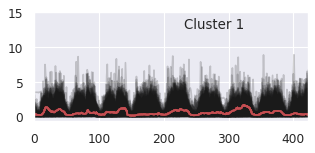

(422, 530, 48)
751400401.905 --> 115536255.736 --> 115426578.730 --> 115401778.974 --> 115404438.049 --> 115410267.309 --> 115406696.527 --> 115354092.458 --> 115360950.905 --> 115354316.249 --> 115359278.779 --> 115359438.505 --> 115356643.037 --> 115356921.593 --> 115355692.353 --> 115354107.011 --> 115345220.790 --> 115347546.441 --> 115343221.915 --> 115346055.812 --> 115337485.719 --> 115345785.840 --> 115336562.654 --> 115338581.566 --> 115327959.241 --> 115328016.996 --> 115323630.800 --> 115324466.143 --> 115322296.372 --> 115322685.029 --> 115321306.868 --> 115321588.169 --> 115320178.004 --> 115320553.540 --> 115319752.091 --> 115320458.272 --> 115318899.186 --> 115317126.317 --> 115321643.262 --> 115317049.953 --> 115323062.784 --> 115313720.257 --> 115311997.539 --> 115307666.670 --> 115304526.775 --> 115299255.305 --> 115299363.876 --> 115294760.034 --> 115294577.409 --> 115285898.956 --> 


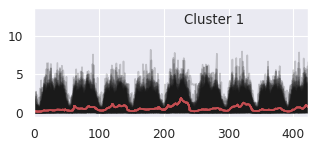

(422, 530, 48)
332120425.990 --> 123512662.163 --> 123413958.254 --> 123332663.922 --> 123379302.138 --> 123317367.266 --> 123327231.266 --> 123301635.157 --> 123313997.434 --> 123280921.724 --> 123291496.294 --> 123273537.690 --> 123284986.683 --> 123270442.588 --> 123273085.966 --> 123263701.495 --> 123261876.997 --> 123194701.645 --> 123222362.363 --> 123186847.815 --> 123189849.964 --> 123179620.203 --> 123182628.859 --> 123176981.002 --> 123182139.209 --> 123176114.987 --> 123178684.942 --> 123172308.260 --> 123175093.976 --> 123171197.317 --> 123175086.333 --> 123171178.543 --> 123178283.581 --> 123173212.587 --> 123177740.952 --> 123175575.707 --> 123178251.171 --> 123176492.775 --> 123177732.396 --> 123175786.209 --> 123177532.585 --> 123175851.195 --> 123177653.087 --> 123175951.915 --> 123177577.659 --> 123173236.068 --> 123173513.084 --> 123171341.766 --> 123172269.764 --> 123170553.540 --> 


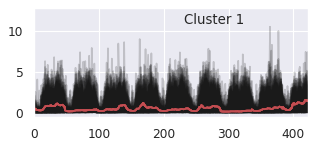

(422, 530, 48)
304587135.279 --> 128481816.987 --> 128345691.634 --> 128303260.354 --> 128256872.674 --> 128236578.747 --> 128220749.736 --> 128202679.557 --> 128161930.100 --> 128162024.828 --> 128129729.585 --> 128121954.585 --> 128069975.776 --> 128074716.515 --> 128056842.168 --> 128051134.715 --> 128040768.305 --> 128044449.261 --> 128040760.828 --> 128041953.951 --> 128036929.878 --> 128037849.987 --> 128035299.660 --> 128035110.779 --> 128038057.319 --> 128034649.651 --> 128033158.646 --> 128042743.257 --> 128043869.562 --> 128042784.268 --> 128042565.735 --> 128044822.040 --> 128044830.124 --> 128043892.882 --> 128043351.775 --> 128042876.114 --> 128043416.266 --> 128042262.887 --> 128039044.004 --> 128036792.866 --> 128035928.913 --> 128033139.305 --> 128027671.009 --> 128023064.617 --> 128008275.929 --> 128003255.361 --> 128003519.089 --> 128002221.810 --> 127999731.967 --> 127996758.471 --> 


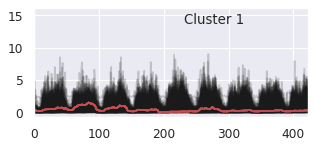

(422, 530, 48)
343664900.264 --> 122579124.022 --> 122480122.676 --> 122440506.547 --> 122409239.230 --> 122380630.004 --> 122377098.057 --> 122338629.622 --> 122267854.778 --> 122289092.372 --> 122250721.667 --> 122251077.778 --> 122233707.371 --> 122234181.200 --> 122222717.322 --> 122217229.068 --> 122198290.918 --> 122191441.019 --> 122179574.910 --> 122172683.364 --> 122167228.273 --> 122163807.868 --> 122158891.084 --> 122156457.191 --> 122154481.211 --> 122154808.663 --> 122151415.963 --> 122150080.791 --> 122147753.899 --> 122149215.485 --> 122147351.032 --> 122148062.284 --> 122146480.759 --> 122141210.854 --> 122134083.113 --> 122132881.954 --> 122129989.735 --> 122130016.374 --> 122128464.184 --> 122128595.489 --> 122126842.197 --> 122126584.970 --> 122124753.130 --> 122124485.771 --> 122123658.808 --> 122124083.785 --> 122122750.396 --> 122123129.434 --> 122122260.410 --> 122122851.070 --> 


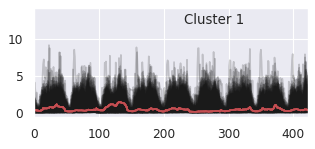

(422, 530, 48)
687091503.435 --> 119368431.831 --> 119222098.443 --> 119143929.994 --> 119113415.777 --> 119079698.270 --> 119085172.351 --> 119046885.402 --> 119051669.393 --> 119025593.453 --> 118975558.077 --> 118932306.496 --> 118744196.112 --> 118812345.727 --> 118740779.390 --> 118749801.660 --> 118701494.950 --> 118582053.971 --> 118550406.527 --> 118575663.985 --> 118545444.481 --> 118557298.624 --> 118534040.433 --> 118544949.191 --> 118469776.484 --> 118505223.084 --> 118452515.182 --> 118446611.847 --> 118439354.472 --> 118436513.125 --> 118429821.354 --> 118434865.706 --> 118428771.987 --> 118419718.222 --> 118409446.046 --> 118381114.842 --> 118380842.336 --> 118362715.168 --> 118363924.432 --> 118358124.177 --> 118357412.288 --> 118353566.784 --> 118351530.185 --> 118351439.182 --> 118345312.132 --> 118338360.368 --> 118333726.974 --> 118331719.746 --> 118327933.384 --> 118328951.401 --> 


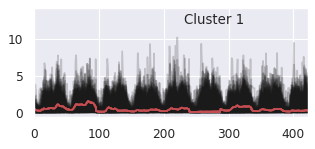

(422, 530, 48)
317609778.604 --> 132366231.954 --> 132141131.469 --> 132122058.263 --> 132089076.924 --> 132118963.320 --> 132078884.140 --> 131999540.483 --> 131948279.924 --> 131927938.338 --> 131899251.234 --> 131905892.783 --> 131897377.855 --> 131897693.554 --> 131891013.259 --> 131894295.126 --> 131880424.158 --> 131882197.616 --> 131880675.155 --> 131887659.500 --> 131884138.900 --> 131888949.162 --> 131882255.042 --> 131884260.829 --> 131886383.868 --> 131872992.272 --> 131876833.160 --> 131868234.051 --> 131876180.584 --> 131866924.309 --> 131873169.936 --> 131864675.565 --> 131860724.142 --> 131860185.666 --> 131856379.167 --> 131847652.672 --> 131839415.923 --> 131835998.926 --> 131828899.451 --> 131836877.367 --> 131821339.987 --> 131828099.143 --> 131807714.473 --> 131802502.425 --> 131776869.883 --> 131774093.770 --> 131771379.981 --> 131772499.797 --> 131770959.317 --> 131769998.422 --> 


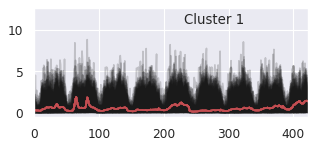

(422, 530, 48)
290338411.516 --> 116796484.780 --> 116622984.910 --> 116513536.776 --> 116399577.034 --> 116356790.500 --> 116279670.276 --> 116195545.237 --> 116135604.643 --> 116083169.765 --> 116019319.365 --> 115963188.754 --> 115911753.815 --> 115876164.628 --> 115848076.861 --> 115820671.636 --> 115785131.704 --> 115748650.736 --> 115721615.106 --> 115694441.263 --> 115683665.248 --> 115654088.536 --> 115619315.002 --> 115587005.258 --> 115555888.249 --> 115548906.201 --> 115539299.215 --> 115533178.772 --> 115527866.161 --> 115519782.366 --> 115516202.910 --> 115507345.743 --> 115497262.754 --> 115491849.389 --> 115485720.810 --> 115478400.056 --> 115460696.080 --> 115446328.167 --> 115441180.041 --> 115415137.874 --> 115390618.736 --> 115366227.876 --> 115363730.646 --> 115359331.457 --> 115355377.181 --> 115347281.565 --> 115344273.941 --> 115337284.825 --> 115333576.490 --> 115328873.171 --> 


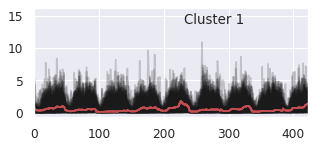

(422, 530, 48)
240136495.730 --> 111905380.635 --> 111852936.544 --> 111843488.093 --> 111819711.408 --> 111822888.905 --> 111784976.564 --> 111772650.636 --> 111798760.482 --> 111780667.404 --> 111763100.392 --> 111738249.868 --> 111725924.731 --> 111729908.799 --> 111720609.963 --> 111721244.891 --> 111714237.032 --> 111713543.156 --> 111707713.580 --> 111707902.723 --> 111701942.082 --> 111703501.342 --> 111698880.825 --> 111700686.644 --> 111697363.728 --> 111698841.489 --> 111695027.834 --> 111697480.403 --> 111694062.316 --> 111696177.494 --> 111693549.013 --> 111696450.542 --> 111698115.169 --> 111702744.867 --> 111700845.541 --> 111702437.761 --> 111700617.650 --> 111702730.545 --> 111701752.892 --> 111703280.337 --> 111702075.444 --> 111704192.196 --> 111702369.564 --> 111702328.522 --> 111701743.584 --> 111702352.596 --> 111701801.926 --> 111701348.253 --> 111700867.456 --> 111701233.594 --> 


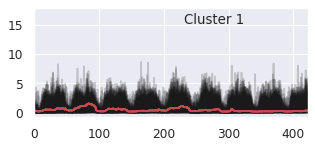

(427, 530, 48)
192728865.400 --> 97239989.502 --> 97196784.716 --> 97201248.624 --> 97206754.600 --> 97162701.666 --> 97184015.291 --> 97144131.507 --> 97162636.008 --> 97123948.174 --> 97055267.368 --> 97071004.937 --> 97031140.254 --> 97026844.656 --> 97006440.902 --> 96999548.903 --> 96993384.243 --> 96989506.707 --> 96986992.797 --> 96982513.179 --> 96981922.552 --> 96975380.462 --> 96974173.413 --> 96970354.969 --> 96971896.202 --> 96968065.783 --> 96964544.990 --> 96967120.349 --> 96966619.397 --> 96970930.933 --> 96959262.219 --> 96964171.125 --> 96963573.995 --> 96961571.102 --> 96966950.513 --> 96965540.717 --> 96976391.010 --> 96969550.247 --> 96972401.406 --> 96965922.871 --> 96969574.657 --> 96963781.810 --> 96966785.108 --> 96960104.480 --> 96962834.895 --> 

In [ ]:
method = "Soft-DTW"


# barycenter_df = pd.DataFrame(columns=['MeterID', 'Day', 'FDI', 'overnight', 'breakfast', 'daytime', 'evening'])
pbar = tqdm(smart_meter_data_group)
count = 1
for area in pbar: # iterate 10 data groups
    X = []
    Y = []
    for meter in area['fdi']: # iterate every fdi meter in area 
        X.append(meter["Electricity"].to_numpy())
        Y.append((meter["MeterID"].max(), 'True'))
    for meter in area['normal']: # iterate every fdi meter in area 
        X.append(meter["Electricity"].to_numpy())
        Y.append((meter["MeterID"].max(), 'False'))
    X = np.array(X)
    Y = np.array(Y)
    X = X.reshape(-1, 530, 48 )
    print(X.shape)
    y_pred, result = km_cluster(X, 1, method)
    SDTW_result[count] = (y_pred, result, result.cluster_centers_, Y)
    count = count + 1

In [ ]:
#save model
one_cluster_sdtw_barycenter = []
for i in range(len(SDTW_result)):
    i = i + 1
    one_cluster_sdtw_barycenter.append(SDTW_result[i][2])
df = pd.DataFrame(one_cluster_sdtw_barycenter[0].reshape(-1, 24))
df.head(), df.shape
e = df.to_csv(index=False)
f = open('one_cluster_softdtw_barycenter_24hours.csv','w')
f.write(e) #Give your csv text here.
f.close()

### read smart meter

In [188]:
smart_meter = pd.read_csv('smart_meter.csv')
print(smart_meter.shape)
n = np.array(smart_meter)
nr = n.reshape(-1, 530, 48, 5)
print(nr.shape)
data_group = {}
for i in range(10):
    if i == 9:
        data_group[i] = nr[4225-427: 4225]
    else:
        data_group[i] = nr[i*422:(i+1)*422]
print(data_group[0][0][0].shape)

(107484000, 5)
(4225, 530, 48, 5)
(48, 5)


###  barycenter euclidean 48

In [134]:
euclidean_barycenter_result = {}
pbar = tqdm(smart_meter_data_group)
count = 1
for area in pbar: # iterate 10 data groups
    print(f'start {count}')
    X = []
    Y = []
    for meter in area['fdi']: # iterate every fdi meter in area 
        X.append(meter["Electricity"].to_numpy())
        Y.append((meter["MeterID"].max(), 'True'))
    for meter in area['normal']: # iterate every fdi meter in area 
        X.append(meter["Electricity"].to_numpy())
        Y.append((meter["MeterID"].max(), 'False'))
    X = np.array(X)
    print(X.shape)
    Y = np.array(Y)
    X = X.reshape(-1, 530, 48 )
    print(X.shape)
    result = euclidean_barycenter(X)
    euclidean_barycenter_result[count] = (result, Y)
    count = count + 1
    
one_cluster_euclidean_barycenter_48 = []
for i in range(len(euclidean_barycenter_result)):
    i = i + 1
    one_cluster_euclidean_barycenter_48.append(euclidean_barycenter_result[i][0])

  0%|          | 0/10 [00:00<?, ?it/s]

start 1
(422, 25440)
(422, 530, 48)
start 2
(422, 25440)
(422, 530, 48)
start 3
(422, 25440)
(422, 530, 48)
start 4
(422, 25440)
(422, 530, 48)
start 5
(422, 25440)
(422, 530, 48)
start 6
(422, 25440)
(422, 530, 48)
start 7
(422, 25440)
(422, 530, 48)
start 8
(422, 25440)
(422, 530, 48)
start 9
(422, 25440)
(422, 530, 48)
start 10
(427, 25440)
(427, 530, 48)


In [164]:
df = pd.DataFrame(np.array(one_cluster_euclidean_barycenter_48).reshape(10, 530*48))
df.shape

(10, 25440)

In [153]:
e = df.to_csv(index=False)
f = open('one_cluster_euclidean_barycenter_48hours.csv','w')
f.write(e) #Give your csv text here.
f.close()

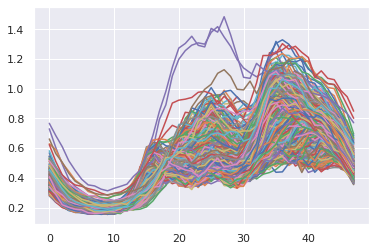

In [150]:
for i in one_cluster_euclidean_barycenter_48[1]:
    plt.plot(i)

In [211]:
from concurrent.futures import ProcessPoolExecutor, ThreadPoolExecutor
from time import time, sleep
global center
offset = 1  # guessing what your offset variable is valued at.


def calc_stuff(x,y):   # these are examples.
    meter_euclid = np.linalg.norm(x-y)
    meter_dtw = dtw(x,y)
    meter_sdtw = soft_dtw(x,y)
    return meter_euclid, meter_dtw, meter_sdtw

def procedure(j):                 # just factoring out the
    df_list = []
    d = j.reshape(-1, 5)
    meter = pd.DataFrame(d, columns=["MeterID","Day","Time","Electricity","FDI"])
    day_list = meter['Day'].reset_index()
    for i in range(530): # 
        
        meter_id = meter["MeterID"].loc[0]
        meter_day = day_list['Day'][i*48]
        meter_fdi = meter["FDI"].loc[0]
        x = meter["Electricity"].to_numpy()[i*48:(i+1)*48]
        y = center[i*48:(i+1)*48]
#         if i == 529:
#             print(f'meter_id : {meter_id} , x.shape :{ x.shape}, y.shape: {y.shape},{i*48,(i+1)*48}')
        meter_euclid, meter_dtw, meter_sdtw = calc_stuff(x,y)
        se = {'MeterID': meter_id, 'Day': meter_day,'FDI': meter_fdi, "meter_euclid": meter_euclid, "meter_dtw":meter_dtw, "meter_sdtw":meter_sdtw}
        df_list.append(se)
    return df_list

def main(PoolExecutor, area_num): # take ProcessPoolExecutor or ThreadPoolExecutor
    
    inputs = data_group[area_num] # data_group[0] 有422個
    output1 = list()

    start = time()           # let's see how long this takes
    
    with PoolExecutor() as executor:
        for out1 in executor.map(procedure, inputs):
            # put results into correct output list:
            output1.append(out1)
            
    finish = time()
    print(f'PoolExecutor: {PoolExecutor}')
    print(f'time : {(finish-start)}')
    return output1

In [194]:
center_euclid_48 = pd.read_csv('one_cluster_euclidean_barycenter_48hours.csv')
center_euclid_48.shape

(10, 25440)

In [212]:
euclid_day_score_list = []
for num in range(10):
    print(f'start area {num}')
    center = center_euclid_48.loc[num].to_numpy()
    sdtwa = main(ProcessPoolExecutor, num)
    euclid_day_score_list.append(sdtwa)

start area 0
PoolExecutor: <class 'concurrent.futures.process.ProcessPoolExecutor'>
time : 24.098092794418335
start area 1
PoolExecutor: <class 'concurrent.futures.process.ProcessPoolExecutor'>
time : 24.07256770133972
start area 2
PoolExecutor: <class 'concurrent.futures.process.ProcessPoolExecutor'>
time : 24.06574845314026
start area 3
PoolExecutor: <class 'concurrent.futures.process.ProcessPoolExecutor'>
time : 24.152065753936768
start area 4
PoolExecutor: <class 'concurrent.futures.process.ProcessPoolExecutor'>
time : 24.30057382583618
start area 5
PoolExecutor: <class 'concurrent.futures.process.ProcessPoolExecutor'>
time : 24.10377788543701
start area 6
PoolExecutor: <class 'concurrent.futures.process.ProcessPoolExecutor'>
time : 24.068072080612183
start area 7
PoolExecutor: <class 'concurrent.futures.process.ProcessPoolExecutor'>
time : 24.27300500869751
start area 8
PoolExecutor: <class 'concurrent.futures.process.ProcessPoolExecutor'>
time : 24.257030248641968
start area 9
Po

In [214]:
score_list = []
area_count = 0
meter_count = 0
day_count = 0

for index, area in enumerate(euclid_day_score_list): # area=10
    area_count += 1
    for meter in area: #meter=422(427)
        meter_count += 1
        for day in meter:
            day_count +=1
            score_list.append(day)
area_count, meter_count, day_count

In [216]:
euclid_day_score_df = pd.DataFrame(score_list)
df = euclid_day_score_df
X = df[["meter_euclid"]]
Y = df[["FDI"]]

partition = 422*8*530
evaluation = 422*1*530
total = 2239250


X_train = X[:partition]
X_val = X[partition:total-evaluation]
X_test = X[total-evaluation: total]
y_train = Y[:partition]
y_val = Y[partition:total-evaluation]
y_test = Y[total-evaluation: total]

In [217]:
X_train.shape, X_val.shape, X_test.shape, y_train.shape, y_val.shape, y_test.shape

((1789280, 1),
 (226310, 1),
 (223660, 1),
 (1789280, 1),
 (226310, 1),
 (223660, 1))

In [218]:
model = XGBClassifier()
# define grid
weights = [0.01, 0.1, 1, 10, 25, 50, 75, 99, 100, 1000, 116,  10.7]
param_grid = dict(scale_pos_weight=weights)
# define evaluation procedure
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# define grid search
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=cv, scoring='roc_auc')
# execute the grid search
grid_result = grid.fit(X_train, y_train, verbose=True)
# report the best configuration
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
# report all configurations
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[22:42:59] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Best: 0.562951 using {'scale_pos_weight': 0.01}
0.562951 (0.002340) with: {'scale_pos_weight': 0.01}
0.562407 (0.002435) with: {'scale_pos_weight': 0.1}
0.562082 (0.002403) with: {'scale_pos_weight': 1}
0.561906 (0.002442) with: {'scale_pos_weight': 10}
0.562130 (0.002341) with: {'scale_pos_weight': 25}
0.562241 (0.002503) with: {'scale_pos_weight': 50}
0.562184 (0.002412) with: {'scale_pos_weight': 75}
0.562169 (0.002428) with: {'scale_pos_weight': 99}
0.562115 (0.002333) with: {'scale_pos_weight': 100}
0.562135 (0.002247) with: {'scale_pos_weight': 1000}
0.562083 (0.002428) with: {'scale_pos_weight': 116}
0.561934 (0.002554) with: {'scale_pos_weight': 10.7}


### barycenter dba 48

In [ ]:
# calculate center
dba_barycenter_result = {}
pbar = tqdm(smart_meter_data_group)
count = 1
for area in pbar: # iterate 10 data groups
    print(f'start {count}')
    X = []
    Y = []
    for meter in area['fdi']: # iterate every fdi meter in area 
        X.append(meter["Electricity"].to_numpy())
        Y.append((meter["MeterID"].max(), 'True'))
    for meter in area['normal']: # iterate every fdi meter in area 
        X.append(meter["Electricity"].to_numpy())
        Y.append((meter["MeterID"].max(), 'False'))
    X = np.array(X)
    print(X.shape)
    Y = np.array(Y)
    X = X.reshape(-1, 530, 48 )
    print(X.shape)
    result = dtw_barycenter_averaging_subgradient(X, max_iter=20, tol=1e-3)
    dba_barycenter_result[count] = (result, Y)
    count = count + 1
    
one_cluster_dba_barycenter_48 = []
for i in range(len(dba_barycenter_result)):
    i = i + 1
    one_cluster_dba_barycenter_48.append(dba_barycenter_result[i][0])
print(one_cluster_dba_barycenter_48[9].shape)

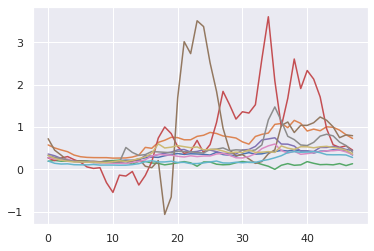

In [163]:
for i in one_cluster_dba_barycenter_48[0][:10]:
    plt.plot(i)
#     break

In [159]:
# df = pd.DataFrame(np.array(one_cluster_dba_barycenter_48).reshape(10, 530*48))
# print(df.shape)
# e = df.to_csv(index=False)
# f = open('one_cluster_dba_barycenter_48.csv','w')
# f.write(e) #Give your csv text here.
# f.close()

(10, 25440)

In [239]:
# func of cal distance
from concurrent.futures import ProcessPoolExecutor, ThreadPoolExecutor
from time import time, sleep
global center
offset = 1  # guessing what your offset variable is valued at.


def calc_stuff(x,y):   # these are examples.
    meter_euclid = np.linalg.norm(x-y)
    meter_dtw = dtw(x,y)
    meter_sdtw = soft_dtw(x,y)
    return meter_euclid, meter_dtw, meter_sdtw

def procedure(j):                 # just factoring out the
    df_list = []
    d = j.reshape(-1, 5)
    meter = pd.DataFrame(d, columns=["MeterID","Day","Time","Electricity","FDI"])
    day_list = meter['Day'].reset_index()
    for i in range(530): # 
        
        meter_id = meter["MeterID"].loc[0]
        meter_day = day_list['Day'][i*48]
        meter_fdi = meter["FDI"].loc[0]
        x = meter["Electricity"].to_numpy()[i*48:(i+1)*48]
        y = center[i*48:(i+1)*48]
#         if i == 529:
#             print(f'meter_id : {meter_id} , x.shape :{ x.shape}, y.shape: {y.shape},{i*48,(i+1)*48}')
        meter_euclid, meter_dtw, meter_sdtw = calc_stuff(x,y)
        se = {'MeterID': meter_id, 'Day': meter_day,'FDI': meter_fdi, "meter_euclid": meter_euclid, "meter_dtw":meter_dtw, "meter_sdtw":meter_sdtw}
        df_list.append(se)
    return df_list

def main(PoolExecutor, area_num): # take ProcessPoolExecutor or ThreadPoolExecutor
    
    inputs = data_group[area_num] # data_group[0] 有422個
    output1 = list()

    start = time()           # let's see how long this takes
    
    with PoolExecutor() as executor:
        for out1 in executor.map(procedure, inputs):
            # put results into correct output list:
            output1.append(out1)
            
    finish = time()
    print(f'PoolExecutor: {PoolExecutor}')
    print(f'time : {(finish-start)}')
    return output1

In [241]:
center_dba_48 = pd.read_csv('one_cluster_dba_barycenter_48.csv')
center_dba_48.shape

(10, 25440)

In [242]:
dba_day_score_list = []
for num in range(10):
    print(f'start area {num}')
    center = center_dba_48.loc[num].to_numpy()
    sdtwa = main(ProcessPoolExecutor, num)
    dba_day_score_list.append(sdtwa)

start area 0
PoolExecutor: <class 'concurrent.futures.process.ProcessPoolExecutor'>
time : 25.19044017791748
start area 1
PoolExecutor: <class 'concurrent.futures.process.ProcessPoolExecutor'>
time : 25.019767999649048
start area 2
PoolExecutor: <class 'concurrent.futures.process.ProcessPoolExecutor'>
time : 24.63744878768921
start area 3
PoolExecutor: <class 'concurrent.futures.process.ProcessPoolExecutor'>
time : 24.71922016143799
start area 4
PoolExecutor: <class 'concurrent.futures.process.ProcessPoolExecutor'>
time : 24.89380121231079
start area 5
PoolExecutor: <class 'concurrent.futures.process.ProcessPoolExecutor'>
time : 24.530025005340576
start area 6
PoolExecutor: <class 'concurrent.futures.process.ProcessPoolExecutor'>
time : 24.678476810455322
start area 7
PoolExecutor: <class 'concurrent.futures.process.ProcessPoolExecutor'>
time : 24.673357725143433
start area 8
PoolExecutor: <class 'concurrent.futures.process.ProcessPoolExecutor'>
time : 24.627437591552734
start area 9
P

In [243]:
# combime score list
score_list = []
area_count = 0
meter_count = 0
day_count = 0
dba_day_score_df = pd.DataFrame(columns=["MeterID", "Day", "FDI", "meter_dtw", "meter_sdtw"])
for index, area in enumerate(dba_day_score_list): # area=10
    area_count += 1
    for meter in area: #meter=422(427)
        meter_count += 1
        for day in meter:
            day_count +=1
            score_list.append(day)
area_count, meter_count, day_count

(10, 4225, 2239250)

In [245]:
X_train.shape, X_val.shape, X_test.shape, y_train.shape, y_val.shape, y_test.shape

((1789280, 1),
 (226310, 1),
 (223660, 1),
 (1789280, 1),
 (226310, 1),
 (223660, 1))

In [ ]:
dba_day_score_df = pd.DataFrame(score_list)
df = dba_day_score_df
X = df[["meter_dtw"]]
Y = df[["FDI"]]

partition = 422*8*530
evaluation = 422*1*530
total = 2239250


X_train = X[:partition]
X_val = X[partition:total-evaluation]
X_test = X[total-evaluation: total]
y_train = Y[:partition]
y_val = Y[partition:total-evaluation]
y_test = Y[total-evaluation: total]

model = XGBClassifier()
# define grid
weights = [0.01, 0.1, 1, 10, 25, 50, 75, 99, 100, 1000, 116,  10.7]
param_grid = dict(scale_pos_weight=weights)
# define evaluation procedure
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# define grid search
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=cv, scoring='roc_auc')
# execute the grid search
grid_result = grid.fit(X_train, y_train, verbose=True)
# report the best configuration
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
# report all configurations
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

In [247]:
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
# report all configurations
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.590014 using {'scale_pos_weight': 0.01}
0.590014 (0.002503) with: {'scale_pos_weight': 0.01}
0.589817 (0.002412) with: {'scale_pos_weight': 0.1}
0.589630 (0.002400) with: {'scale_pos_weight': 1}
0.589043 (0.002299) with: {'scale_pos_weight': 10}
0.588588 (0.002304) with: {'scale_pos_weight': 25}
0.588654 (0.002504) with: {'scale_pos_weight': 50}
0.588758 (0.002330) with: {'scale_pos_weight': 75}
0.588820 (0.002414) with: {'scale_pos_weight': 99}
0.588675 (0.002384) with: {'scale_pos_weight': 100}
0.588630 (0.002199) with: {'scale_pos_weight': 1000}
0.588618 (0.002316) with: {'scale_pos_weight': 116}
0.589110 (0.002332) with: {'scale_pos_weight': 10.7}


### barycenter sdtw 48

In [75]:
barycenter_result = {}
pbar = tqdm(smart_meter_data_group)
count = 1
for area in pbar: # iterate 10 data groups
    print(f'start {count}')
    X = []
    Y = []
    for meter in area['fdi']: # iterate every fdi meter in area 
        X.append(meter["Electricity"].to_numpy())
        Y.append((meter["MeterID"].max(), 'True'))
    for meter in area['normal']: # iterate every fdi meter in area 
        X.append(meter["Electricity"].to_numpy())
        Y.append((meter["MeterID"].max(), 'False'))
    X = np.array(X)
    print(X.shape)
    Y = np.array(Y)
    X = X.reshape(-1, 530, 48 )
    print(X.shape)
    result = softdtw_barycenter(X, max_iter=5, gamma=1.)
    barycenter_result[count] = (result, Y)
    count = count + 1

  0%|          | 0/10 [00:00<?, ?it/s]

start 1
(422, 25440)
(422, 530, 48)
start 2
(422, 25440)
(422, 530, 48)
start 3
(422, 25440)
(422, 530, 48)
start 4
(422, 25440)
(422, 530, 48)
start 5
(422, 25440)
(422, 530, 48)
start 6
(422, 25440)
(422, 530, 48)
start 7
(422, 25440)
(422, 530, 48)
start 8
(422, 25440)
(422, 530, 48)
start 9
(422, 25440)
(422, 530, 48)
start 10
(427, 25440)
(427, 530, 48)


In [76]:
one_cluster_sdtw_barycenter_48 = []
for i in range(len(barycenter_result)):
    i = i + 1
    one_cluster_sdtw_barycenter_48.append(barycenter_result[i][0])


In [131]:
one_cluster_sdtw_barycenter_48[9].shape

(530, 48)

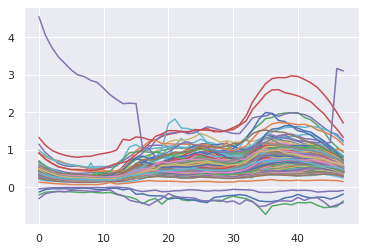

In [133]:
for i in one_cluster_sdtw_barycenter_48[0]:
    plt.plot(i)

In [80]:
df = pd.DataFrame(np.array(one_cluster_sdtw_barycenter_48).reshape(10, 530*48))
df.shape

(10, 25440)

In [81]:
e = df.to_csv(index=False)
f = open('one_cluster_sdtw_barycenter_48.csv','w')
f.write(e) #Give your csv text here.
f.close()

In [249]:
center_sdtw_48 = pd.read_csv('one_cluster_sdtw_barycenter_48.csv')
center_sdtw_48.shape

(10, 25440)

In [250]:
sdtw_day_score_list = []
for num in range(10):
    print(f'start area {num}')
    center = center_sdtw_48.loc[num].to_numpy()
    sdtwa = main(ProcessPoolExecutor, num)
    sdtw_day_score_list.append(sdtwa)

start area 0
PoolExecutor: <class 'concurrent.futures.process.ProcessPoolExecutor'>
time : 24.768401384353638
start area 1
PoolExecutor: <class 'concurrent.futures.process.ProcessPoolExecutor'>
time : 24.698643684387207
start area 2
PoolExecutor: <class 'concurrent.futures.process.ProcessPoolExecutor'>
time : 24.62259078025818
start area 3
PoolExecutor: <class 'concurrent.futures.process.ProcessPoolExecutor'>
time : 24.891225337982178
start area 4
PoolExecutor: <class 'concurrent.futures.process.ProcessPoolExecutor'>
time : 25.22414207458496
start area 5
PoolExecutor: <class 'concurrent.futures.process.ProcessPoolExecutor'>
time : 25.045814752578735
start area 6
PoolExecutor: <class 'concurrent.futures.process.ProcessPoolExecutor'>
time : 25.11192488670349
start area 7
PoolExecutor: <class 'concurrent.futures.process.ProcessPoolExecutor'>
time : 24.841408491134644
start area 8
PoolExecutor: <class 'concurrent.futures.process.ProcessPoolExecutor'>
time : 24.853843450546265
start area 9


In [252]:
# combime score list
score_list = []
area_count = 0
meter_count = 0
day_count = 0
sdtw_day_score_list = pd.DataFrame(columns=["MeterID", "Day", "FDI", "meter_dtw", "meter_sdtw"])
for index, area in enumerate(sdtw_day_score_list): # area=10
    area_count += 1
    for meter in area: #meter=422(427)
        meter_count += 1
        for day in meter:
            day_count +=1
            score_list.append(day)
area_count, meter_count, day_count

(5, 32, 32)

In [ ]:
sdtw_day_score_list = pd.DataFrame(score_list)
df = sdtw_day_score_list
X = df[["meter_dtw"]]
Y = df[["FDI"]]

partition = 422*8*530
evaluation = 422*1*530
total = 2239250

print(X_train.shape, X_val.shape, X_test.shape, y_train.shape, y_val.shape, y_test.shape)

X_train = X[:partition]
X_val = X[partition:total-evaluation]
X_test = X[total-evaluation: total]
y_train = Y[:partition]
y_val = Y[partition:total-evaluation]
y_test = Y[total-evaluation: total]

model = XGBClassifier()
# define grid
weights = [0.01, 0.1, 1, 10, 25, 50, 75, 99, 100, 1000, 116,  10.7]
param_grid = dict(scale_pos_weight=weights)
# define evaluation procedure
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# define grid search
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=cv, scoring='roc_auc')
# execute the grid search
grid_result = grid.fit(X_train, y_train, verbose=True)
# report the best configuration
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
# report all configurations
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

In [254]:
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
# report all configurations
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.590014 using {'scale_pos_weight': 0.01}
0.590014 (0.002503) with: {'scale_pos_weight': 0.01}
0.589817 (0.002412) with: {'scale_pos_weight': 0.1}
0.589630 (0.002400) with: {'scale_pos_weight': 1}
0.589043 (0.002299) with: {'scale_pos_weight': 10}
0.588588 (0.002304) with: {'scale_pos_weight': 25}
0.588654 (0.002504) with: {'scale_pos_weight': 50}
0.588758 (0.002330) with: {'scale_pos_weight': 75}
0.588820 (0.002414) with: {'scale_pos_weight': 99}
0.588675 (0.002384) with: {'scale_pos_weight': 100}
0.588630 (0.002199) with: {'scale_pos_weight': 1000}
0.588618 (0.002316) with: {'scale_pos_weight': 116}
0.589110 (0.002332) with: {'scale_pos_weight': 10.7}


## Final sdtw day score calculating

## MIC

In [85]:
smart_meter_data_mic = []
for area in smart_meter_data_group:
    
    for meter in area['fdi']:
        t = meter['Electricity'].to_numpy().reshape(530, 48)
        smart_meter_data_mic.append(t)
    for meter in area['normal']:
        t = meter['Electricity'].to_numpy().reshape(530, 48)
        smart_meter_data_mic.append(t)
        
smart_meter_data_mic = np.asarray(smart_meter_data_mic)

In [86]:
smart_meter_data_mic.shape

(4225, 530, 48)

In [89]:
ntl_loss_data_group.shape, ntl_loss_data_group[0].shape

((10, 530, 48), (530, 48))

In [93]:
ntl_loss_data_group[0][0]

array([0.06646936, 0.02996372, 0.0527681 , 0.03172372, 0.03585797,
       0.02698641, 0.02740628, 0.02551334, 0.02193757, 0.01042044,
       0.11481782, 0.07485002, 0.08220286, 0.1004776 , 0.18969537,
       0.10098957, 0.18327169, 0.11422056, 0.12890305, 0.08336046,
       0.05552484, 0.06628611, 0.05052802, 0.04232441, 0.15173175,
       0.17253823, 0.20369852, 0.12317874, 0.02453935, 0.10987744,
       0.05497007, 0.06268045, 0.05586385, 0.12405256, 0.12959462,
       0.05688207, 0.14093927, 0.12296265, 0.13289415, 0.12750397,
       0.1231144 , 0.12201188, 0.06921831, 0.07826877, 0.10229957,
       0.07115736, 0.0315797 , 0.04234233])

In [103]:
# calculate MIC 
m = MINE(alpha=0.8)
mic_result = []
pbar = tqdm(smart_meter_data_group)
# ntl_loss_data_group, smart_meter_data_group

for area_num, area in enumerate(pbar): # iterate 10 data groups
    loss_list = ntl_loss_data_group[area_num]
    for meter in area['fdi']: # iterate every fdi meter in area +
        day_list = meter['Day'].reset_index()
        for i in range(NUMBER_OF_DAYS): # iterate every day
            meter_id = meter['MeterID'].max()
            meter_day = day_list['Day'][i*48]
#             meter_fdi = meter["FDI"].loc[0]
            u = meter["Electricity"].to_numpy()[i*48:(i+1)*48]
            e = loss_list[i]
            m.compute_score(u, e)
            mic_value = m.mic()
            se = {'MeterID': meter_id, 'Day': meter_day,'FDI': True, "mic":round(mic_value, 6)}
            mic_result.append(se)
    for meter in area['normal']:
        day_list = meter['Day'].reset_index()
        for i in range(NUMBER_OF_DAYS): # iterate every day
            meter_id = meter['MeterID'].max()
            meter_day = day_list['Day'][i*48]
#             meter_fdi = meter["FDI"].loc[0]
            u = meter["Electricity"].to_numpy()[i*48:(i+1)*48]
            e = loss_list[i]
            
            m.compute_score(u, e)
            mic_value = m.mic()
            se = {'MeterID': meter_id, 'Day': meter_day,'FDI': False, "mic":mic_value}
            mic_result.append(se)

  0%|          | 0/10 [00:00<?, ?it/s]

In [110]:
mic = pd.DataFrame(mic_result)

In [111]:
e = mic.to_csv(index=False)
f = open('mic.csv','w')
f.write(e) #Give your csv text here.
## Python will convert \n to os.linesep
f.close()

# Training

### xgboost (mic only)


In [115]:
xgbc = XGBClassifier()

In [116]:
mic = pd.read_csv('mic.csv')

In [119]:
partition = 422*9*530
X_train = mic[["mic"]][:partition]
X_test = mic[["mic"]][partition:2239250]
y_train = mic[["FDI"]][:partition]
y_test = mic[["FDI"]][partition:2239250]

X = sdtw_day_score_df[["meter_dtw"]]
Y = sdtw_day_score_df[["FDI"]]

partition = 422*8*530
evaluation = 422*1*530
total = 2239250


X_train = X[:partition]
X_val = X[partition:total-evaluation]
X_test = X[total-evaluation: total]
y_train = Y[:partition]
y_val = Y[partition:total-evaluation]
y_test = Y[total-evaluation: total]

In [120]:
model = XGBClassifier()
# define grid
weights = [0.01, 0.1, 1, 10, 25, 50, 75, 99, 100, 1000, 116,  10.7]
param_grid = dict(scale_pos_weight=weights)
# define evaluation procedure
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# define grid search
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=cv, scoring='roc_auc')
# execute the grid search
grid_result = grid.fit(X_train, y_train, verbose=True)
# report the best configuration
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
# report all configurations
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[20:04:15] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Best: 0.671522 using {'scale_pos_weight': 1000}
0.599686 (0.002805) with: {'scale_pos_weight': 0.01}
0.634248 (0.002814) with: {'scale_pos_weight': 0.1}
0.666209 (0.003286) with: {'scale_pos_weight': 1}
0.649926 (0.002823) with: {'scale_pos_weight': 10}
0.646517 (0.004372) with: {'scale_pos_weight': 25}
0.651731 (0.003483) with: {'scale_pos_weight': 50}
0.657171 (0.002179) with: {'scale_pos_weight': 75}
0.659887 (0.002061) with: {'scale_pos_weight': 99}
0.659557 (0.002566) with: {'scale_pos_weight': 100}
0.671522 (0.003643) with: {'scale_pos_weight': 1000}
0.662187 (0.002164) with: {'scale_pos_weight': 116}
0.649341 (0.003361) with: {'scale_pos_weight': 10.7}


### xgboost (four time only)

In [129]:
xgbc = XGBClassifier()

In [124]:
four_time = pd.read_csv('four_time.csv')

In [128]:
X = four_time[["overnight", "breakfast", "daytime", "evening"]]
Y = four_time[["FDI"]]

partition = 422*8*530
evaluation = 422*1*530
total = 2239250


X_train = X[:partition]
X_val = X[partition:total-evaluation]
X_test = X[total-evaluation: total]
y_train = Y[:partition]
y_val = Y[partition:total-evaluation]
y_test = Y[total-evaluation: total]

X_train.shape, X_val.shape, X_test.shape, y_train.shape, y_val.shape, y_test.shape

((1789280, 4),
 (226310, 4),
 (223660, 4),
 (1789280, 1),
 (226310, 1),
 (223660, 1))

In [130]:
model = XGBClassifier()
# define grid
weights = [0.01, 0.1, 1, 10, 25, 50, 75, 99, 100, 1000, 116,  10.7]
param_grid = dict(scale_pos_weight=weights)
# define evaluation procedure
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# define grid search
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=cv, scoring='roc_auc')
# execute the grid search
grid_result = grid.fit(X_train, y_train, verbose=True)
# report the best configuration
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
# report all configurations
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_search.py:921: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan]
  category=UserWarning
/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[05:00:45] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Best: nan using {'scale_pos_weight': 0.01}
nan (nan) with: {'scale_pos_weight': 0.01}
nan (nan) with: {'scale_pos_weight': 0.1}
nan (nan) with: {'scale_pos_weight': 1}
nan (nan) with: {'scale_pos_weight': 10}
nan (nan) with: {'scale_pos_weight': 25}
nan (nan) with: {'scale_pos_weight': 50}
nan (nan) with: {'scale_pos_weight': 75}
nan (nan) with: {'scale_pos_weight': 99}
nan (nan) with: {'scale_pos_weight': 100}
nan (nan) with: {'scale_pos_weight': 1000}
nan (nan) with: {'scale_pos_weight': 116}
nan (nan) with: {'scale_pos_weight': 10.7}


### adaboost and xgboost on 48 hours 

In [42]:
X = df['Electricity']

In [56]:
X = np.array(X).reshape(-1, 48)

In [68]:
X = pd.DataFrame(X)

In [77]:
X = X.apply(pd.to_numeric)

In [71]:
Y = df[df['Time']==1]['FDI']

In [98]:
Y = Y=="True"

In [73]:
average_score = {}
average_score["precision_score"] = 0
average_score["recall_score"] = 0
average_score["accuracy_score"] = 0
average_score["roc_auc_score"] = 0
average_score["f1_score"] = 0

In [52]:
partition = 422*8*530
evaluation = 422*1*530
total = 2239250
split_num = 3

In [99]:
X_train = X[:partition+evaluation]
y_train = Y[:partition+evaluation]

sss = StratifiedShuffleSplit(n_splits=split_num, test_size=0.2, random_state=1)
for train_index, test_index in sss.split(X_train, y_train):
    test_index = np.concatenate((np.array(test_index), np.array(X[total-(partition+evaluation): total].index)))
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    Y_train, Y_test = np.array(Y.iloc[train_index]).reshape(-1) , np.array(Y.iloc[test_index]).reshape(-1)

    model = XGBClassifier()
    model.fit(X_train, Y_train)
    y_hat = model.predict(X_test)
    average_score["precision_score"] += precision_score(Y_test, y_hat)
    average_score["recall_score"] += recall_score(Y_test, y_hat)
    average_score["accuracy_score"] += accuracy_score(Y_test, y_hat)
    average_score["roc_auc_score"] += roc_auc_score(Y_test, y_hat)
    average_score["f1_score"] += f1_score(Y_test, y_hat)

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:57:09] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:58:38] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[21:00:09] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [100]:
for key, score in average_score.items():
    average_score[key] = score / split_num
    print("average_" + key + ": " + str(average_score[key]))

average_precision_score: 0.8816309535587393
average_recall_score: 0.1540207549973783
average_accuracy_score: 0.9146958070174858
average_roc_auc_score: 0.5758816234674247
average_f1_score: 0.26222888191446136


In [114]:
average_score = {}
average_score["precision_score"] = 0
average_score["recall_score"] = 0
average_score["accuracy_score"] = 0
average_score["roc_auc_score"] = 0
average_score["f1_score"] = 0

In [115]:
split_num = 1

In [116]:
X_train = X[:partition+evaluation]
y_train = Y[:partition+evaluation]

sss = StratifiedShuffleSplit(n_splits=split_num, test_size=0.2, random_state=1)
for train_index, test_index in sss.split(X_train, y_train):
    test_index = np.concatenate((np.array(test_index), np.array(X[total-(partition+evaluation): total].index)))
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    Y_train, Y_test = np.array(Y.iloc[train_index]).reshape(-1) , np.array(Y.iloc[test_index]).reshape(-1)

    model = AdaBoostClassifier()
    model.fit(X_train, Y_train)
    y_hat = model.predict(X_test)
    average_score["precision_score"] += precision_score(Y_test, y_hat)
    average_score["recall_score"] += recall_score(Y_test, y_hat)
    average_score["accuracy_score"] += accuracy_score(Y_test, y_hat)
    average_score["roc_auc_score"] += roc_auc_score(Y_test, y_hat)
    average_score["f1_score"] += f1_score(Y_test, y_hat)

In [117]:
for key, score in average_score.items():
    average_score[key] = score / 1
    print("average_" + key + ": " + str(average_score[key]))

average_precision_score: 0.7466625865432429
average_recall_score: 0.08210028684628909
average_accuracy_score: 0.9069102076233436
average_roc_auc_score: 0.5395295512577644
average_f1_score: 0.1479342632274982


## testing dataset

In [5]:
def concat_two_df_and_drop_same_column_in_df2(DF1, DF2):
    display(DF1.head(1))
    display(DF2.head(1))
    DF2.drop(DF2.columns[DF2.columns.isin(DF1.columns)],axis=1,inplace=True)
#     DF1.drop(DF1.columns[DF1.columns.isin(DF2.columns)],axis=1,inplace=True)
    result = pd.concat([DF1, DF2], axis=1)
    display(result.head(1))
    return result
def count_list_val(arr):
    values, counts = np.unique(arr, return_counts=True)
    print(values, counts)

In [6]:
four_time = pd.read_csv("CSV/four_time.csv")
v_value = pd.read_csv("CSV/v_value.csv")
mic = pd.read_csv("CSV/mic.csv")
dwt_distance = pd.read_csv("CSV/sdtw_day_score_df.csv")

In [7]:
four_time.shape, v_value.shape, mic.shape, dwt_distance.shape

((2239250, 7), (2239250, 9), (2239250, 4), (1817089, 5))

In [8]:
result = concat_two_df_and_drop_same_column_in_df2(v_value, four_time)
result = concat_two_df_and_drop_same_column_in_df2(result, mic)
result = concat_two_df_and_drop_same_column_in_df2(result, dwt_distance)
result.columns

,MeterID,Day,FDI,Tmax1,Tmax2,Tmin1,Cmax1,Cmax2,Cmin1
0,5212,2010-12-31,True,12,30,15,0.046464,0.047532,0.013561


,MeterID,Day,FDI,overnight,breakfast,daytime,evening
0,1236,2009-07-15,True,5.380015,15.5,24.5,38.0


,MeterID,Day,FDI,Tmax1,Tmax2,Tmin1,Cmax1,Cmax2,Cmin1,overnight,breakfast,daytime,evening
0,5212,2010-12-31,True,12,30,15,0.046464,0.047532,0.013561,5.380015,15.5,24.5,38.0


,MeterID,Day,FDI,Tmax1,Tmax2,Tmin1,Cmax1,Cmax2,Cmin1,overnight,breakfast,daytime,evening
0,5212,2010-12-31,True,12,30,15,0.046464,0.047532,0.013561,5.380015,15.5,24.5,38.0


,MeterID,Day,FDI,mic
0,1236,2009-07-15,True,0.624128


,MeterID,Day,FDI,Tmax1,Tmax2,Tmin1,Cmax1,Cmax2,Cmin1,overnight,breakfast,daytime,evening,mic
0,5212,2010-12-31,True,12,30,15,0.046464,0.047532,0.013561,5.380015,15.5,24.5,38.0,0.624128


,MeterID,Day,FDI,Tmax1,Tmax2,Tmin1,Cmax1,Cmax2,Cmin1,overnight,breakfast,daytime,evening,mic
0,5212,2010-12-31,True,12,30,15,0.046464,0.047532,0.013561,5.380015,15.5,24.5,38.0,0.624128


,MeterID,Day,FDI,meter_dtw,meter_sdtw
0,1236,2009-07-15,True,2.283294,-68.276715


,MeterID,Day,FDI,Tmax1,Tmax2,Tmin1,Cmax1,Cmax2,Cmin1,overnight,breakfast,daytime,evening,mic,meter_dtw,meter_sdtw
0,5212,2010-12-31,True,12,30,15,0.046464,0.047532,0.013561,5.380015,15.5,24.5,38.0,0.624128,2.283294,-68.276715


Index(['MeterID', 'Day', 'FDI', 'Tmax1', 'Tmax2', 'Tmin1', 'Cmax1', 'Cmax2',
       'Cmin1', 'overnight', 'breakfast', 'daytime', 'evening', 'mic',
       'meter_dtw', 'meter_sdtw'],
      dtype='object')

### xgboost model

In [127]:
def train_model(df, x_col, y_col, score = False, split_num = 3, return_model=False ):
    
    X = df[x_col]
    Y = df[y_col]

    partition = 422*8*530
    evaluation = 422*1*530
    total = 2239250

    round = 1
    average_score = {}
    average_score["precision_score"] = 0
    average_score["recall_score"] = 0
    average_score["accuracy_score"] = 0
    average_score["roc_auc_score"] = 0
    average_score["f1_score"] = 0

    X_train = X[:partition+evaluation]
    y_train = Y[:partition+evaluation]

    sss = StratifiedShuffleSplit(n_splits=split_num, test_size=0.2, random_state=1)
    for train_index, test_index in sss.split(X_train, y_train):
        test_index = np.concatenate((np.array(test_index), np.array(X[total-(partition+evaluation): total].index)))
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        Y_train, Y_test = np.array(Y.iloc[train_index]).reshape(-1) , np.array(Y.iloc[test_index]).reshape(-1)

        model = XGBClassifier(scale_pos_weight=10)
        model.fit(X_train, Y_train)
        y_hat = model.predict(X_test)
        average_score["precision_score"] += precision_score(Y_test, y_hat)
        average_score["recall_score"] += recall_score(Y_test, y_hat)
        average_score["accuracy_score"] += accuracy_score(Y_test, y_hat)
        average_score["roc_auc_score"] += roc_auc_score(Y_test, y_hat)
        average_score["f1_score"] += f1_score(Y_test, y_hat)

        if score:
            print("round: " + str(round))
            print("precision score: " + str(precision_score(Y_test, y_hat)))
            print("recall_score: " + str(recall_score(Y_test, y_hat)))
            print("accuracy_score: " + str(accuracy_score(Y_test, y_hat)))
            print("roc_auc_score: " + str(roc_auc_score(Y_test, y_hat)))
            print("f1_score: " + str(f1_score(Y_test, y_hat)))
            print()

        round += 1
    for key, score in average_score.items():
        average_score[key] = score / split_num
        print("average_" + key + ": " + str(average_score[key]))
    if return_model=True:
        return model, average_score
    return average_score

In [ ]:
col = ['overnight', 'breakfast', 'daytime', 'evening',
       'Tmax1', 'Tmax2', 'Tmin1', 'Cmax1', 'Cmax2', 'Cmin1', 'mic',
       'meter_dtw', 'meter_sdtw']
train_model(result, col, ['FDI'])

In [ ]:
col = ['overnight', 'breakfast', 'daytime', 'evening']
train_model(result, col, ['FDI'])

In [ ]:
col = ['Tmax1', 'Tmax2', 'Tmin1', 'Cmax1', 'Cmax2', 'Cmin1']
train_model(result, col, ['FDI'])

In [ ]:
col = ['mic']
train_model(result, col, ['FDI'])

In [ ]:
col = ['meter_dtw', 'meter_sdtw']
train_model(result, col, ['FDI'])

### adaboost model

In [ ]:
def train_ada_model(df, x_col, y_col, score = False, split_num = 3):
    
    X = df[x_col]
    Y = df[y_col]

    partition = 422*8*530
    evaluation = 422*1*530
    total = 2239250

    round = 1
    average_score = {}
    average_score["precision_score"] = 0
    average_score["recall_score"] = 0
    average_score["accuracy_score"] = 0
    average_score["roc_auc_score"] = 0
    average_score["f1_score"] = 0

    X_train = X[:partition+evaluation]
    y_train = Y[:partition+evaluation]

    sss = StratifiedShuffleSplit(n_splits=split_num, test_size=0.2, random_state=1)
    for train_index, test_index in sss.split(X_train, y_train):
        test_index = np.concatenate((np.array(test_index), np.array(X[total-(partition+evaluation): total].index)))
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        Y_train, Y_test = np.array(Y.iloc[train_index]).reshape(-1) , np.array(Y.iloc[test_index]).reshape(-1)

        model = AdaBoostClassifier()
        model.fit(X_train, Y_train)
        y_hat = model.predict(X_test)
        average_score["precision_score"] += precision_score(Y_test, y_hat)
        average_score["recall_score"] += recall_score(Y_test, y_hat)
        average_score["accuracy_score"] += accuracy_score(Y_test, y_hat)
        average_score["roc_auc_score"] += roc_auc_score(Y_test, y_hat)
        average_score["f1_score"] += f1_score(Y_test, y_hat)

        if score:
            print("round: " + str(round))
            print("precision score: " + str(precision_score(Y_test, y_hat)))
            print("recall_score: " + str(recall_score(Y_test, y_hat)))
            print("accuracy_score: " + str(accuracy_score(Y_test, y_hat)))
            print("roc_auc_score: " + str(roc_auc_score(Y_test, y_hat)))
            print("f1_score: " + str(f1_score(Y_test, y_hat)))
            print()

        round += 1
    for key, score in average_score.items():
        average_score[key] = score / split_num
        print("average_" + key + ": " + str(average_score[key]))
    return average_score

In [ ]:
col = ['meter_dtw', 'meter_sdtw']
train_ada_model(result, col, ['FDI'])

In [ ]:
col = ['mic']
train_ada_model(result, col, ['FDI'])

In [ ]:
col = ['overnight', 'breakfast', 'daytime', 'evening']
train_ada_model(result, col, ['FDI'])

In [ ]:
col = ['Tmax1', 'Tmax2', 'Tmin1', 'Cmax1', 'Cmax2', 'Cmin1']
train_ada_model(result, col, ['FDI'])

In [ ]:
col = ['overnight', 'breakfast', 'daytime', 'evening',
       'Tmax1', 'Tmax2', 'Tmin1', 'Cmax1', 'Cmax2', 'Cmin1', 'mic',
       'meter_dtw', 'meter_sdtw']
train_ada_model(result, col, ['FDI'])

## permutation importance

In [9]:
col = ['overnight', 'breakfast', 'daytime', 'evening',
       'Tmax1', 'Tmax2', 'Tmin1', 'Cmax1', 'Cmax2', 'Cmin1', 'mic',
       'meter_dtw', 'meter_sdtw']
X = result[col]
Y = result['FDI']

In [ ]:
model = XGBClassifier()
# define grid
weights = [0.1, 1, 10, 25, 50, 75, 100, 10.7]
param_grid = dict(scale_pos_weight=weights)
# define evaluation procedure
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# define grid search
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=cv, scoring='roc_auc')
# execute the grid search
grid_result = grid.fit(X_train, y_train)
# report the best configuration
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
# report all configurations
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

In [ ]:
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

In [12]:
partition = 422*8*530
evaluation = 422*1*530
total = 2239250

X_train = X[:partition+evaluation]
y_train = Y[:partition+evaluation]
X_val = X[partition:]
y_val = Y[partition:]

In [11]:
model = XGBClassifier(scale_pos_weight=10.7).fit(X_train, y_train)

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:49:12] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [14]:
r = permutation_importance(model, X_val, y_val, n_repeats=30, random_state=0)

In [16]:
print(r.importances_mean)
print(r.importances_std)
# for i in r.importances_mean.argsort()[::-1]:
#     if r.importances_mean[i] - 2 * r.importances_std[i] > 0:
#         print(f"{diabetes.feature_names[i]:<8}"
#               f"{r.importances_mean[i]:.3f}"
#               f" +/- {r.importances_std[i]:.3f}")

[ 2.04235838e-04  9.29691609e-04  1.18393078e-03  1.72841152e-03
  6.59525450e-04  3.01131187e-04 -8.48204695e-05  2.56661555e-03
  2.83900408e-03  4.89980814e-03  4.63482751e-03  2.69757243e-02
  3.00554852e-02]
[8.43044226e-05 5.54890871e-05 6.92983724e-05 7.45956163e-05
 7.76297511e-05 5.51241939e-05 4.85816581e-05 8.13568689e-05
 8.59202867e-05 1.14531065e-04 1.30369044e-04 5.80429746e-05
 6.43386354e-05]


In [20]:
four_time_importance = sum(r.importances_mean[:3])
mic_importance = r.importances_mean[10]
v_value_importance = sum(r.importances_mean[4:10])
dtw_importance = r.importances_mean[11]
sdtw_importance = r.importances_mean[12]

In [25]:
importance = { "four_time": four_time_importance, "mic": mic_importance, "v_value": v_value_importance, "dtw": dtw_importance, "sdtw": sdtw_importance}

In [39]:
importance = dict(sorted(importance.items(), key=lambda item: item[1], reverse=True))

In [40]:
list(importance.values())

[0.03005548518049356,
 0.02697572430754648,
 0.011181263936114539,
 0.004634827507019038,
 0.002317858227585701]

Saving figure Permutation importance


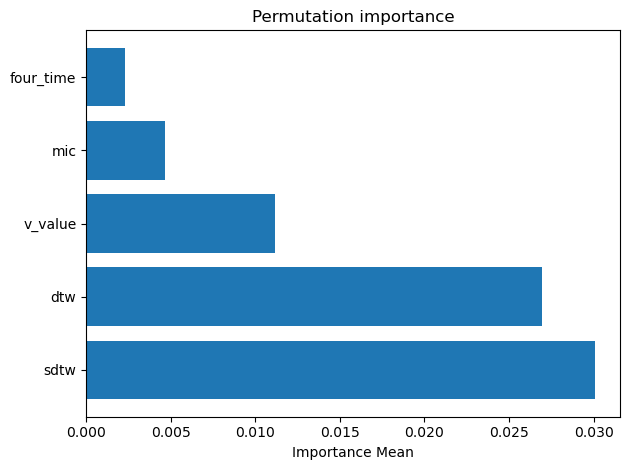

In [44]:
y_label = list(importance.keys())
y_pos = np.arange(len(importance))

plt.rcdefaults()
fig, ax = plt.subplots()

ax.barh(y_pos, list(importance.values()), align='center')

ax.set_yticks(y_pos)
ax.set_yticklabels(y_label)

ax.set_xlabel('Importance Mean')
ax.set_title('Permutation importance')
save_fig('Permutation importance')